# Data Driven Gait Analysis

### TRA105 Digitalization in Sports

#### Group Members:
 - David Larsson [larsdav@student.chalmers.se]
 - Savya Sachi Gupta [savya@student.chalmers.se]
 
 ---
 ---
 
 In this notebook, we will be looking at two methods we employed to build models to identify 'Gait' in skiers, i.e., Random Forest Classifier and Multiclass Logistic Regression. Each of these methods will be trained on a set of skier data and validated using skiers data that has not been used to train or tune the model. Further details regarding the setup of these experiments has been provided in their respective sections. Please note that this notebook focuses on only the implementation of classification models and their performance on data. Any information regarding the raw data, pre-processing of raw data, cleaning, preparation etc can be found within the files present in the `functions` folder of this package.
 
 ## Instructions:
  - Please ensure that all packages/libraries/dependencies are installed on your system
  - Two user defined libraries are present in the 'functions' folder of this package which are accessed by the first two lines of the importing libraries module. If you are unable to access them via the folder, you may copy and paste both the files in the same directory as this notebook and edit the import command accordingly to simply reflect the filenames
  - Under the 'Loading the Dataset' code block, you will see `path_first` and `path_second` that point to the raw skier data that we want to load. Please ensure that these paths exist on your system and their relative filepath as specified in the variables are functioning for you.
  - **Note**: The following are the user defined functions that have been used in this notebook:
      - from `functions.dataframe_functions`:
         - `get_dataframe_with_shift` : function to load all skier data into this notebook. It also shifts the data by 12 seconds to align it with the gears specified in the data more accurately
      - from `functions.analysis_setup_functions`:
         - `split_train_test_data` : function to split skier data into train and validation datasets. Randomly selects `validation_skiers = 3` to randomly select 3 skiers from the entire list to consider as validation data and the remaining as training data.
         - `tune_random_forest` : Function to perform hyperparameter tuning for a random forest classifier model
         - `tune_logistic_regression` : Function to perform hyperparameter tuning for a multiclass logistic regression model
         - `evaluate` : Function to predict labels for the validation data. Performs 5-fold cross-validation and returns confusion matrix, classifier performance metrics. It is a generic function and is used for both random forest and logistic regression. 
         - `plot_predicted_gear_comparison` : plots the true labels of the validation data as a line plot and superimposes a scatterplot with the predicted labels to visually show the accuracy of the model in classifying the gears. We have the Gear Numbers on the y-axis and No. of observations on the x-axis.

**You can understand more about these functions by reading through their files where they have been defined and explained in detail**



##### Importing Libraries

In [1]:
from functions.dataframe_functions import *
from functions.analysis_setup_functions import *

from IPython.display import HTML
import pandas as pd
import numpy as np
import random as rnd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn import metrics

##### Loading the Dataset

We load the entire dataset of all the skiers together, so that we can later split into trianing and test according to our convenience. If you want to change the number of skiers that should be chosen for validation, please change the `validation_skiers` variable to a number of your choice. We have set it to 3. `df_info` is the dataframe which contains all the information useful for running our model and that is the one used by us in this notebook.

In [2]:
path_first = "../matlab_report-master/Treadmill/Test/Torsby/"
skier_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
path_second = "/CSV/csvData.csv"
filepath_list = [path_first + str(i) + path_second for i in skier_list]

main_df, df_peaks, df_info = get_dataframe_with_shift(filepath_list, skier_list)

# No. of Skiers to use for testing
validation_skiers = 3

---
---
---
# RANDOM FOREST CLASSIFIER
---

Now that we have our data loaded from the above code block, we will see how well a random forest classifier method performs in identifying the gears. The execution of our experiment using random forest classifier will be carried out in the following steps:
 - Load training and validation data based on randomly selected skiers
 - Perform hyperparameter tuning for a random forest classifier model on this dataset
 - Evaluate the validation data using the tuned model and return performance metrics for this model
 - Plot the predicted and True gears of validation data to visualize quality of predictions made
 - Store all results
 - **Repeat all the above steps again**
 
The experiment is performed within the `for` loop which is used to repeat the experiments for 5 runs (in our case). We will then view the results across all the runs and see if the performance of this method is consistent, and share our observations.


Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 3, 4, 6, 7, 8, 10]
Validation Skiers : [5, 9, 1]


Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'n_estimators': 97, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 80, 'class_weight': 'balanced', 'bootstrap': False}


Evaluating Validation Data with 5-fold CV...



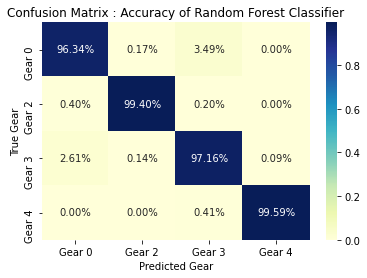

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------
Accuracy Score: 0.972
Balanced Accuracy Score: 0.981
MCC Score: 0.956
F-1 Score (Macro Avg): 0.98
Classifier Score: 0.878

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1774
           2       0.99      0.99      0.99       501
           3       0.97      0.97      0.97      2147
           4       0.99      1.00      0.99       245

    accuracy                           0.97      4667
   macro avg       0.98      0.98      0.98      4667
weighted avg       0.97      0.97      0.97      4667



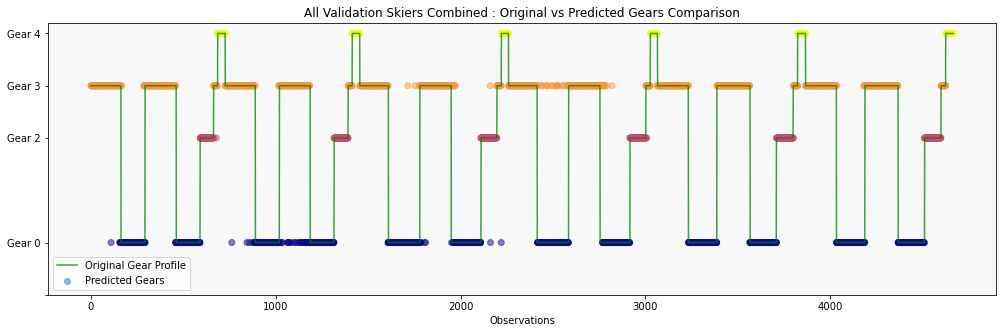





Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 4, 5, 6, 8, 10]
Validation Skiers : [9, 7, 3]


Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 80, 'class_weight': 'balanced', 'bootstrap': False}


Evaluating Validation Data with 5-fold CV...



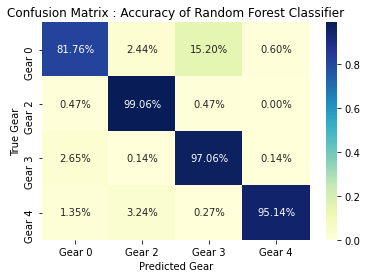

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------
Accuracy Score: 0.915
Balanced Accuracy Score: 0.933
MCC Score: 0.874
F-1 Score (Macro Avg): 0.928
Classifier Score: 0.838

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.82      0.88      1842
           2       0.91      0.99      0.95       635
           3       0.88      0.97      0.92      2112
           4       0.96      0.95      0.96       370

    accuracy                           0.91      4959
   macro avg       0.93      0.93      0.93      4959
weighted avg       0.92      0.91      0.91      4959



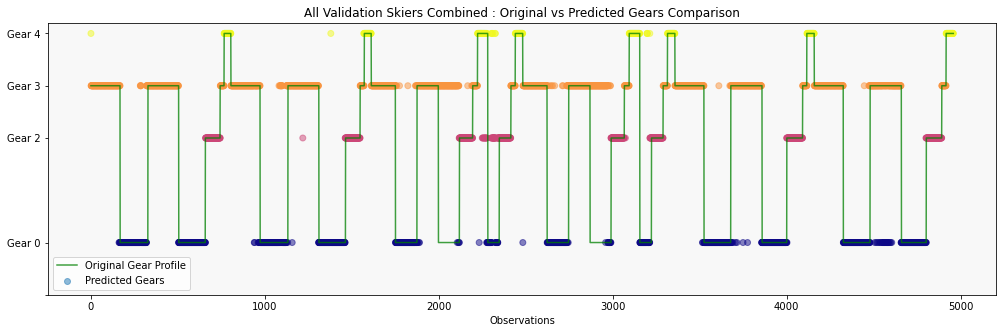





Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 3, 4, 5, 6, 8, 10]
Validation Skiers : [7, 2, 9]


Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'n_estimators': 28, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 50, 'class_weight': 'balanced_subsample', 'bootstrap': True}


Evaluating Validation Data with 5-fold CV...



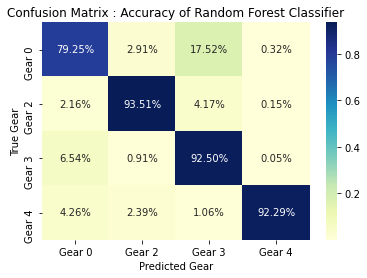

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------
Accuracy Score: 0.877
Balanced Accuracy Score: 0.894
MCC Score: 0.815
F-1 Score (Macro Avg): 0.895
Classifier Score: 0.831

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.79      0.84      1855
           2       0.88      0.94      0.91       647
           3       0.84      0.93      0.88      2080
           4       0.98      0.92      0.95       376

    accuracy                           0.88      4958
   macro avg       0.90      0.89      0.90      4958
weighted avg       0.88      0.88      0.88      4958



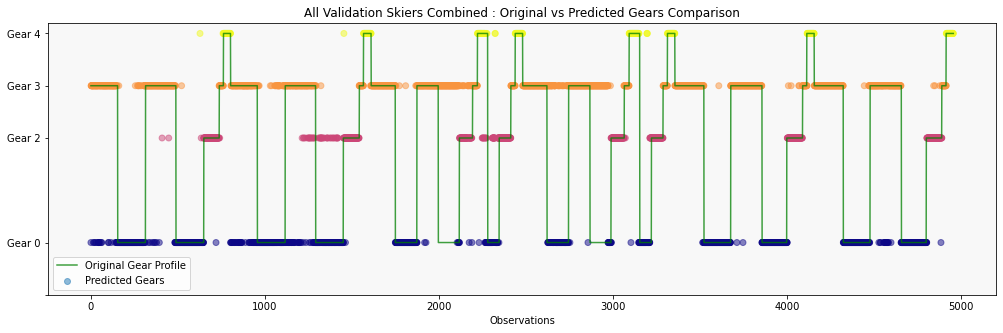





Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 4, 5, 7, 10]
Validation Skiers : [8, 6, 9]


Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'n_estimators': 51, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': False}


Evaluating Validation Data with 5-fold CV...



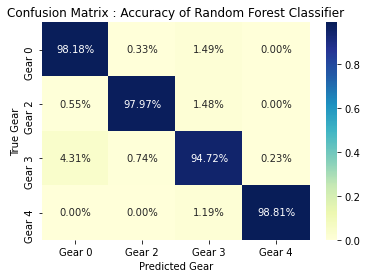

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------
Accuracy Score: 0.966
Balanced Accuracy Score: 0.974
MCC Score: 0.947
F-1 Score (Macro Avg): 0.971
Classifier Score: 0.948

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      1810
           2       0.96      0.98      0.97       541
           3       0.98      0.95      0.96      2159
           4       0.98      0.99      0.98       252

    accuracy                           0.97      4762
   macro avg       0.97      0.97      0.97      4762
weighted avg       0.97      0.97      0.97      4762



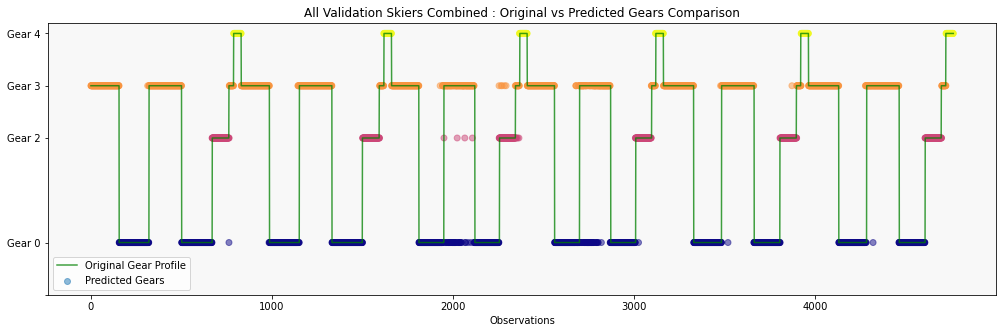





Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 3, 4, 6, 7, 8, 9]
Validation Skiers : [5, 1, 10]


Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 90, 'class_weight': 'balanced_subsample', 'bootstrap': False}


Evaluating Validation Data with 5-fold CV...



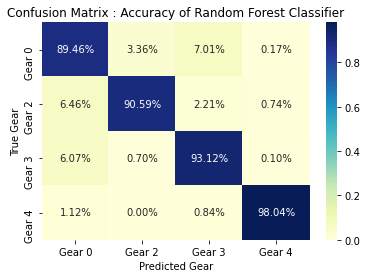

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------
Accuracy Score: 0.918
Balanced Accuracy Score: 0.928
MCC Score: 0.876
F-1 Score (Macro Avg): 0.925
Classifier Score: 0.86

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1727
           2       0.87      0.91      0.89       542
           3       0.93      0.93      0.93      1992
           4       0.97      0.98      0.98       357

    accuracy                           0.92      4618
   macro avg       0.92      0.93      0.92      4618
weighted avg       0.92      0.92      0.92      4618



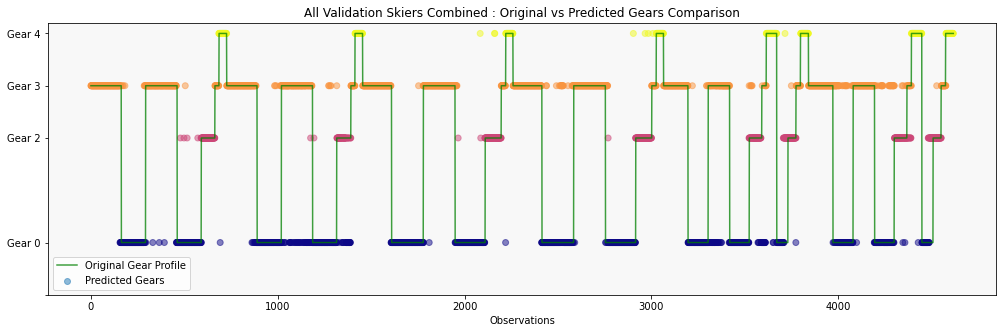

In [20]:
# Create a dataframe that will store data for every run in one table
rfc_results_df = pd.DataFrame(columns=list(['Training Skiers','Validation Skiers','Best Hyperparameters',
                                           'Accuracy','Balanced Accuracy','MCC','F1 (Macro Avg)','Classifier Score',
                                           'Classification Report']))

for i in range(0,5):

    #Load training and validation data based on randomly selected skiers
    X_train, X_valid, y_train, y_valid, y_plot_data, train_skiers_list, val_skiers_list = split_train_test_data(df_info, skier_list, validation_skiers)
    
    display(HTML(f'<p><strong><span style="font-size: 24px; color: rgb(0, 168, 133);">Case {i+1} : Training Skiers : {train_skiers_list}  ||  Validation Skiers : {val_skiers_list}</span></strong></p>'))
    
    # Perform hyperparameter tuning for a random forest classifier model on this dataset
    rfc, rfc_best_params = tune_random_forest(X_train, y_train)

    # Evaluate the model using validation data and output performance metrics
    results, all_y_pred, CM_arr, class_report = evaluate(rfc,X_valid, y_valid, 'Random Forest Classifier')
    
    # Plot the predicted and True gears of validation data to visualize quality of predictions made
    plot_predicted_gear_comparison(y_plot_data,all_y_pred,False)
    
    # Store all results
    temp_all_metrics =  ["" for x in range(9)]
    temp_all_metrics[0] = train_skiers_list
    temp_all_metrics[1] = val_skiers_list
    temp_all_metrics[2] = rfc_best_params
    temp_all_metrics[3] = results[0]
    temp_all_metrics[4] = results[1]
    temp_all_metrics[5] = results[5]
    temp_all_metrics[6] = results[4]
    temp_all_metrics[7] = results[9]
    temp_all_metrics[8] = class_report
    
    rfc_results_df.loc[len(rfc_results_df)] = temp_all_metrics
    
    print('\n\n')

## Summary of RFC Model Across 5 Runs

In [23]:
rfc_results_df

,Training Skiers,Validation Skiers,Best Hyperparameters,Accuracy,Balanced Accuracy,MCC,F1 (Macro Avg),Classifier Score,Classification Report
0,"[2, 3, 4, 6, 7, 8, 10]","[5, 9, 1]","{'n_estimators': 97, 'min_samples_split': 4, '...",0.972,0.981,0.956,0.980,0.878,precision recall f1-score ...
1,"[1, 2, 4, 5, 6, 8, 10]","[9, 7, 3]","{'n_estimators': 120, 'min_samples_split': 2, ...",0.915,0.933,0.874,0.928,0.838,precision recall f1-score ...
2,"[1, 3, 4, 5, 6, 8, 10]","[7, 2, 9]","{'n_estimators': 28, 'min_samples_split': 6, '...",0.877,0.894,0.815,0.895,0.831,precision recall f1-score ...
3,"[1, 2, 3, 4, 5, 7, 10]","[8, 6, 9]","{'n_estimators': 51, 'min_samples_split': 2, '...",0.966,0.974,0.947,0.971,0.948,precision recall f1-score ...
4,"[2, 3, 4, 6, 7, 8, 9]","[5, 1, 10]","{'n_estimators': 74, 'min_samples_split': 4, '...",0.918,0.928,0.876,0.925,0.860,precision recall f1-score ...


In [47]:
rfc_results_df.describe()

,Accuracy,Balanced Accuracy,MCC,F1 (Macro Avg),Classifier Score
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.929600,0.942000,0.893600,0.939800,0.871000
std,0.039488,0.035798,0.058346,0.035195,0.046872
min,0.877000,0.894000,0.815000,0.895000,0.831000
25%,0.915000,0.928000,0.874000,0.925000,0.838000
50%,0.918000,0.933000,0.876000,0.928000,0.860000
75%,0.966000,0.974000,0.947000,0.971000,0.878000
max,0.972000,0.981000,0.956000,0.980000,0.948000


## Observations

As we can see, the Random Forest Classifier performs excellently in predicting the gears across all runs on the validation dataset. Across 5 runs, we get a Mean Accuracy of **`0.929`** and a Mean Balanced Accuracy of **`0.942`** with a Mean MCC Score of **`0.893`** which indicates that this is a great classifier for our data. 

If we look at all our Cases above, **Case 1** performed the best with near perfect classification of our data. Across all our cases, visually we can see through the gear profile comparison that Gear 0 was incorrectly predicted most often, and usually confused the Gear 3. 

---
---
---
# Multiclass Logistic Regression
---
In this section, we will see how well multiclass logistic regression performs in identifying the gears. The execution of our experiment using this method will be carried out in the following steps, similar to the random forest method:
 - Load training and validation data based on randomly selected skiers
 - Perform hyperparameter tuning for a multiclass logistic regression model on this dataset
 - Evaluate the validation data using the tuned model and return performance metrics for this model
 - Plot the predicted and True gears of validation data to visualize quality of predictions made
 - Store all results
 - **Repeat all the above steps again**
 
The experiment is performed within the `for` loop which is used to repeat the experiments for 5 runs (in our case). We will then view the results across all the runs and see if the performance of this method is consistent, and share our observations.


Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 3, 4, 5, 6, 8, 9]
Validation Skiers : [10, 7, 1]


Performing Hyperparameter Tuning...



C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Best Parameters after Randomized Search CV : 
{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 6500, 'dual': True, 'class_weight': 'balanced', 'C': 1.0}




C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Evaluating Validation Data with 5-fold CV...



C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

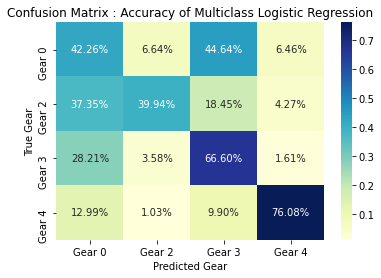

Performance Metrics for Multiclass Logistic Regression :
----------------------------------------------------------
Accuracy Score: 0.552
Balanced Accuracy Score: 0.562
MCC Score: 0.335
F-1 Score (Macro Avg): 0.564
Classifier Score: 0.616

Classification Report: 
               precision    recall  f1-score   support

           0       0.46      0.42      0.44      1687
           2       0.58      0.40      0.47       656
           3       0.58      0.67      0.62      1925
           4       0.69      0.76      0.72       485

    accuracy                           0.55      4753
   macro avg       0.58      0.56      0.56      4753
weighted avg       0.55      0.55      0.55      4753



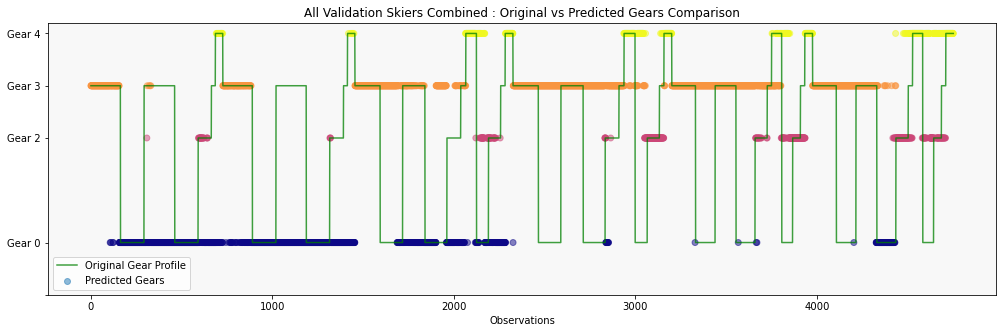





Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 3, 4, 7, 8, 9, 10]
Validation Skiers : [1, 5, 6]


Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 6300, 'dual': False, 'class_weight': 'balanced', 'C': 92.1055317689482}


Evaluating Validation Data with 5-fold CV...



C:\Users\savya\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\savya\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\savya\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\savya\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\savya\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

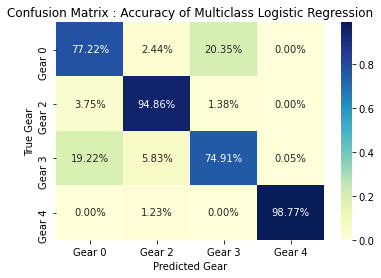

Performance Metrics for Multiclass Logistic Regression :
----------------------------------------------------------
Accuracy Score: 0.792
Balanced Accuracy Score: 0.864
MCC Score: 0.676
F-1 Score (Macro Avg): 0.842
Classifier Score: 0.749

Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1848
           2       0.74      0.95      0.83       506
           3       0.81      0.75      0.78      2128
           4       1.00      0.99      0.99       244

    accuracy                           0.79      4726
   macro avg       0.83      0.86      0.84      4726
weighted avg       0.79      0.79      0.79      4726



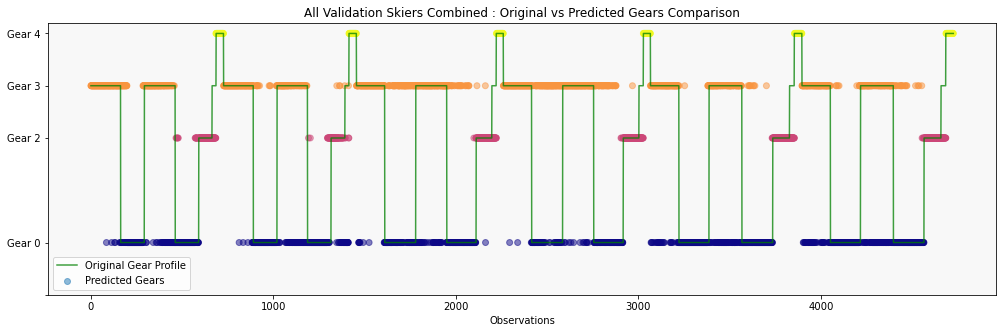





Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 5, 6, 7, 8]
Validation Skiers : [9, 10, 4]


Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 3800, 'dual': False, 'class_weight': 'balanced', 'C': 5.179474679231212}


Evaluating Validation Data with 5-fold CV...



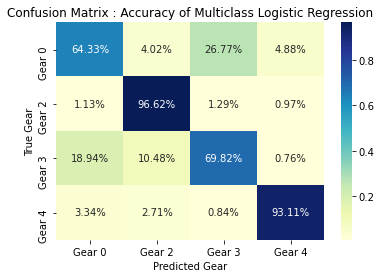

Performance Metrics for Multiclass Logistic Regression :
----------------------------------------------------------
Accuracy Score: 0.736
Balanced Accuracy Score: 0.81
MCC Score: 0.622
F-1 Score (Macro Avg): 0.767
Classifier Score: 0.712

Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.64      0.69      1741
           2       0.67      0.97      0.79       621
           3       0.74      0.70      0.72      1975
           4       0.81      0.93      0.87       479

    accuracy                           0.74      4816
   macro avg       0.74      0.81      0.77      4816
weighted avg       0.74      0.74      0.73      4816



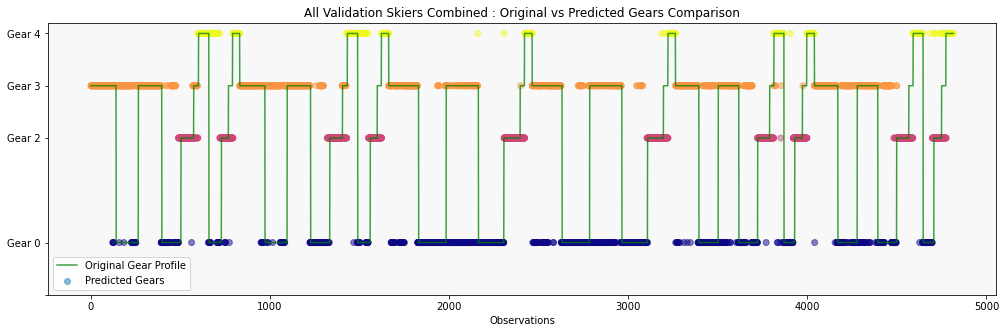





Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 3, 4, 7, 8, 9, 10]
Validation Skiers : [2, 5, 6]


Performing Hyperparameter Tuning...



C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Best Parameters after Randomized Search CV : 
{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 6800, 'dual': True, 'class_weight': 'balanced', 'C': 316.22776601683796}




C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Evaluating Validation Data with 5-fold CV...



C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\savya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

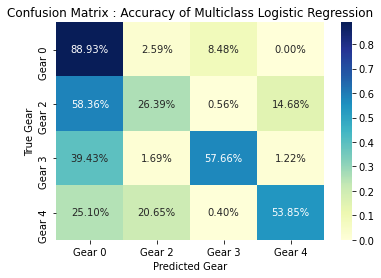

Performance Metrics for Multiclass Logistic Regression :
----------------------------------------------------------
Accuracy Score: 0.666
Balanced Accuracy Score: 0.567
MCC Score: 0.491
F-1 Score (Macro Avg): 0.575
Classifier Score: 0.445

Classification Report: 
               precision    recall  f1-score   support

           0       0.59      0.89      0.71      1969
           2       0.51      0.26      0.35       538
           3       0.88      0.58      0.70      2128
           4       0.56      0.54      0.55       247

    accuracy                           0.67      4882
   macro avg       0.63      0.57      0.58      4882
weighted avg       0.70      0.67      0.66      4882



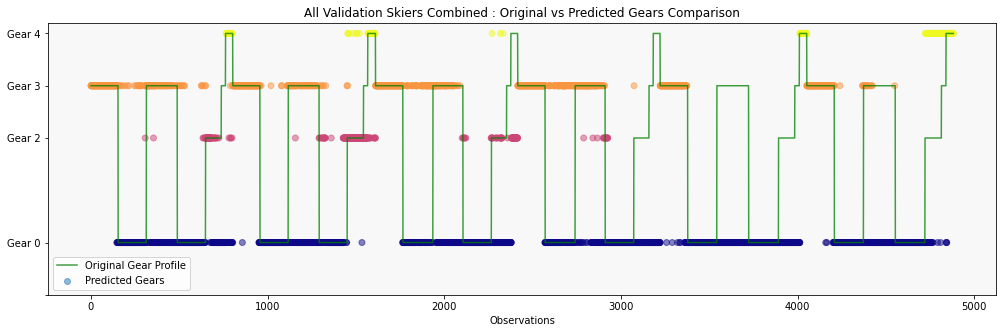





Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 3, 4, 5, 6, 7, 10]
Validation Skiers : [9, 2, 8]


Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 9100, 'dual': False, 'class_weight': 'balanced', 'C': 138.94954943731375}


Evaluating Validation Data with 5-fold CV...



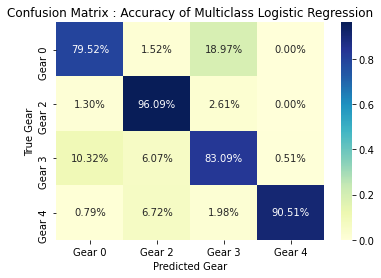

Performance Metrics for Multiclass Logistic Regression :
----------------------------------------------------------
Accuracy Score: 0.836
Balanced Accuracy Score: 0.873
MCC Score: 0.746
F-1 Score (Macro Avg): 0.857
Classifier Score: 0.756

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1782
           2       0.75      0.96      0.84       537
           3       0.83      0.83      0.83      2141
           4       0.95      0.91      0.93       253

    accuracy                           0.84      4713
   macro avg       0.85      0.87      0.86      4713
weighted avg       0.84      0.84      0.84      4713



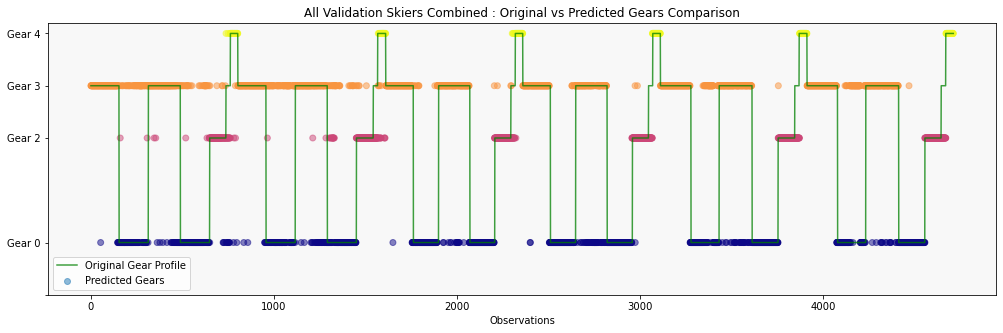

In [3]:
# # Create a dataframe that will store data for every run in one table
lr_results_df = pd.DataFrame(columns=list(['Training Skiers','Validation Skiers','Best Hyperparameters',
                                           'Accuracy','Balanced Accuracy','MCC','F1 (Macro Avg)','Classifier Score',
                                           'Classification Report']))

for i in range(0,5):

    # Load training and validation data based on randomly selected skiers
    X_train, X_valid, y_train, y_valid, y_plot_data, train_skiers_list, val_skiers_list = split_train_test_data(df_info, skier_list, validation_skiers)
    
    display(HTML(f'<p><strong><span style="font-size: 24px; color: rgb(0, 168, 133);">Case {i+1} : Training Skiers : {train_skiers_list}  ||  Validation Skiers : {val_skiers_list}</span></strong></p>'))
    
    # Perform hyperparameter tuning for a multiclass logistic regression model on this dataset
    lr, lr_best_params = tune_logistic_regression(X_train, y_train)

    # Evaluate the model using validation data and output performance metrics
    results, all_y_pred, CM_arr, class_report = evaluate(lr, X_valid, y_valid, 'Multiclass Logistic Regression')

    # Plot the predicted and True gears of validation data to visualize quality of predictions made
    plot_predicted_gear_comparison(y_plot_data,all_y_pred,False)
    
    # Store all results
    temp_all_metrics =  ["" for x in range(9)]
    temp_all_metrics[0] = train_skiers_list
    temp_all_metrics[1] = val_skiers_list
    temp_all_metrics[2] = lr_best_params
    temp_all_metrics[3] = results[0]
    temp_all_metrics[4] = results[1]
    temp_all_metrics[5] = results[5]
    temp_all_metrics[6] = results[4]
    temp_all_metrics[7] = results[9]
    temp_all_metrics[8] = class_report
    
    lr_results_df.loc[len(lr_results_df)] = temp_all_metrics
    
    print('\n\n')

## Summary of Multiclass Logistic Regression over 5 Runs

In [4]:
lr_results_df

,Training Skiers,Validation Skiers,Best Hyperparameters,Accuracy,Balanced Accuracy,MCC,F1 (Macro Avg),Classifier Score,Classification Report
0,"[2, 3, 4, 5, 6, 8, 9]","[10, 7, 1]","{'solver': 'liblinear', 'penalty': 'l2', 'max_...",0.552,0.562,0.335,0.564,0.616,precision recall f1-score ...
1,"[2, 3, 4, 7, 8, 9, 10]","[1, 5, 6]","{'solver': 'newton-cg', 'penalty': 'l2', 'max_...",0.792,0.864,0.676,0.842,0.749,precision recall f1-score ...
2,"[1, 2, 3, 5, 6, 7, 8]","[9, 10, 4]","{'solver': 'newton-cg', 'penalty': 'l2', 'max_...",0.736,0.810,0.622,0.767,0.712,precision recall f1-score ...
3,"[1, 3, 4, 7, 8, 9, 10]","[2, 5, 6]","{'solver': 'liblinear', 'penalty': 'l2', 'max_...",0.666,0.567,0.491,0.575,0.445,precision recall f1-score ...
4,"[1, 3, 4, 5, 6, 7, 10]","[9, 2, 8]","{'solver': 'liblinear', 'penalty': 'l2', 'max_...",0.836,0.873,0.746,0.857,0.756,precision recall f1-score ...


In [5]:
lr_results_df.describe()

,Accuracy,Balanced Accuracy,MCC,F1 (Macro Avg),Classifier Score
count,5.000000,5.000000,5.00000,5.000000,5.000000
mean,0.716400,0.735200,0.57400,0.721000,0.655600
std,0.111771,0.157689,0.16302,0.142494,0.130293
min,0.552000,0.562000,0.33500,0.564000,0.445000
25%,0.666000,0.567000,0.49100,0.575000,0.616000
50%,0.736000,0.810000,0.62200,0.767000,0.712000
75%,0.792000,0.864000,0.67600,0.842000,0.749000
max,0.836000,0.873000,0.74600,0.857000,0.756000


## Observations

As we can see, a Mean MCC Score of **`0.57`** and Mean accuracy of **`0.716`** make the multiclass logistic regression a poor choice in comparison to the random forest classifier method. There are some Cases above where we get accuracy around 0.8, but there are still a lot of incorrectly classified gears. It could be possible that the results might improve over other combination of samples, but the long execution time, issues with convergence of solvers for large iterations and below par results do not encourage us to pursue this method further for analysis or investigation. 

---
---
---